[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/guidedbackprop/blob/master/guidedbackprop.ipynb)

In [0]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [2]:
!pip install torch
!pip install torchvision
!pip install pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/6e/27/709a8493071ec649a56d5a3194f648ec7cd792189e994bbd2ef5d285670d/Pillow-5.2.0-cp27-cp27mu-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Using cached https://files.pythonhosted.org/packages/89/99/0e3522a9764fe371bf9f7729404b1ef7d9c4fc49cbe5f1761c6e07812345/Pillow-4.0.0-cp27-cp27mu-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms,models
from PIL import Image
from torch import nn

In [0]:
mean=torch.Tensor([0.485, 0.456, 0.406])
std=torch.Tensor([0.229, 0.224, 0.225])

def transformimage(image):
  transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean,std)])
  transformedimage=transform(image)
  transformedimage=transformedimage.unsqueeze(0)
  return transformedimage
  
untransform=transforms.ToPILImage()
grayscale=transforms.Grayscale()
def showimage(transformedimage,show,gradient):
    untrans_image=transformedimage.squeeze(0)
    if show==True:
       for i in range(untrans_image.shape[0]):
           untrans_image[i]=(untrans_image[i]*std[i])+mean[i]
    elif gradient==True:
         untrans_image=(untrans_image-untrans_image.min())/untrans_image.max()
    untrans_image=untransform(untrans_image)
    plt.figure()
    plt.imshow(untrans_image)
    plt.show()
    return untrans_image


def grayscale(image):
   image=image.squeeze(0)
   image_mean=torch.mean(image,dim=0)
   plt.figure()
   plt.imshow(image_mean)
   plt.figure()
  
def saliency_map(image):
   image=image.squeeze(0)
   image_max=torch.max(image,dim=0)
   plt.figure()
   plt.imshow(image_max[0])
   plt.figure()
   
def saliencypos_map(image):
   image=image.squeeze(0)
   image_pos=np.maximum(0,image)/image.max()
   plt.figure()
   plt.imshow(untransform(image_pos))
   plt.figure()
  
def saliencyneg_map(image):
   image=image.squeeze(0)
   image_pos=np.maximum(0,-image)/-image.min()
   plt.figure()
   plt.imshow(untransform(image_pos))
   plt.figure()

In [0]:
listofimages=[['drive/app/goldfish.jpg',1],
              ['drive/app/hamster.jpg',333],
              ['drive/app/jellyfish.jpg',107]]
index=1
imgpath=listofimages[index][0]
classid=listofimages[index][1]
model=models.vgg19(pretrained=True)
image=Image.open(imgpath)
imagetensor=transformimage(image)



In [0]:
class guidedbackprop():
  def __init__(self,model):
    self.model=model
    self.relus()
    self.model.eval()
  
  def relus(self):
    def reluhook(layer,grad_in,grad_out):
      return (torch.clamp(grad_in[0],min=0),)
    for layer in self.model.features:
      if isinstance(layer,nn.ReLU):
        layer.register_backward_hook(reluhook)
        
  
  
    
    
guided=guidedbackprop(model)

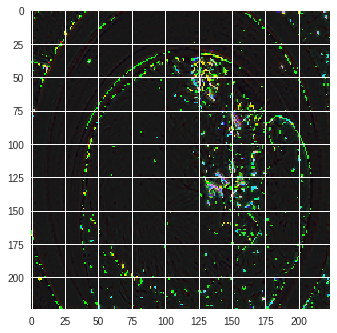

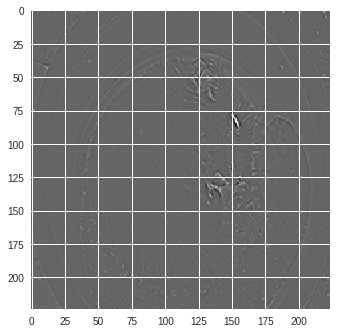

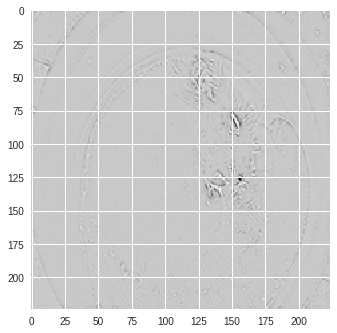

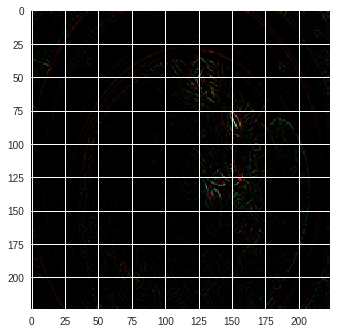

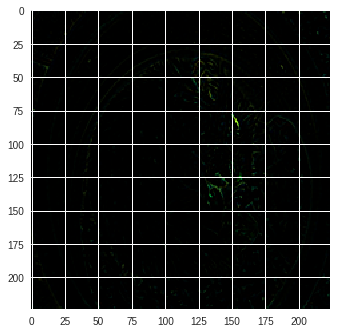

In [31]:
def imagevaluation(imageten):
    model.zero_grad()
    output=model(imageten)
    gradient=torch.zeros_like(output)
    gradient[0][classid]=1
    output.backward(gradient)
    return imageten.grad.data
imagetensor.requires_grad=True
image1=imagevaluation(imagetensor)
image=showimage(image1,False,True)
grayscale(image1)
saliency_map(image1)
saliencypos_map(image1)
saliencyneg_map(image1)